# Mahalanobis Distance Method for Detecting Non-Plant Inputs

## Introduction
The goal is to enhance the plant disease detection model (MobileNet) to identify non-plant inputs without restructuring and retraining the entire model. The Mahalanobis Distance Method is an effective approach for this purpose. This method involves calculating the distribution (mean and standard deviation) of the output of the last feature layer and using these statistics to detect inputs that significantly deviate from this distribution.

## Why Use Mahalanobis Distance?
1. **Preserves Model Structure**: No need to retrain or alter the existing MobileNet model.
2. **Statistical Robustness**: Mahalanobis distance takes into account the correlations between features, providing a more accurate measure of distance in high-dimensional space.
3. **Efficiency**: Once the mean and covariance matrix are computed, the distance calculation is computationally efficient.

## Implementation Steps
1. **Feature Extraction**: Extract the output from the last feature layer of the MobileNet model for a set of plant images.
2. **Distribution Calculation**: Compute the mean vector and covariance matrix of these feature vectors.
3. **Distance Measurement**: For a new input, calculate its feature vector and compute its Mahalanobis distance from the plant distribution.
4. **Thresholding**: Determine a threshold distance (e.g., 3 standard deviations) to classify an input as a non-plant if its distance exceeds this threshold.


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from PIL import Image
import yaml

In [6]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

BASE_PATH = "./"
DATA_DIR = os.path.join(BASE_PATH, 'DATASETS/merged_resized_pngs_splited/train')
NUM_CLASSES = len(os.listdir(os.path.join(BASE_PATH, f"{DATA_DIR}")))
MODEL_PATH = 'models/MobileNetV2_20240531_021014/best_model.pth'

dataset = ImageFolder(DATA_DIR, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
classes = os.listdir(os.path.join(BASE_PATH, DATA_DIR))
classes.sort()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenetv2_base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenetv2_base_model.classifier[1] = nn.Linear(mobilenetv2_base_model.last_channel, 64)
mobilenetv2_base_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
mobilenetv2_base_model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### Clean The Corrupted Data

In [99]:
from PIL import Image, UnidentifiedImageError

def clean_corrupted_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'rb') as f:
                        img = Image.open(f)
                        img.verify()  # Doğrulama işlemi gerçekleştir.
                except (IOError, UnidentifiedImageError):
                    print(f"Bozuk dosya siliniyor: {file_path}")
                    os.remove(file_path)  # Dosyayı sil.
                except Exception as e:
                    print(f"Diğer hata: {e} - {file_path}")
        print(f"{root} klasörü temizlendi.")

clean_corrupted_images(DATA_DIR)

./DATASETS/merged_resized_pngs_splited/train klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Apple__black_rot klasörü temizlendi.
Bozuk dosya siliniyor: ./DATASETS/merged_resized_pngs_splited/train\Apple__healthy\Train_794.png
./DATASETS/merged_resized_pngs_splited/train\Apple__healthy klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Apple__rust klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Apple__scab klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Cherry__healthy klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Cherry__powdery_mildew klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Corn__common_rust klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Corn__gray_leaf_spot klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Corn__healthy klasörü temizlendi.
./DATASETS/merged_resized_pngs_splited/train\Corn__northern_leaf_blight klasörü temizlendi.
./DATASETS/me

#### Extract Features from the Last Layer of MobileNet

In [102]:
def extract_and_save_features(model, dataloader, device, save_dir):
    model.eval()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            outputs = outputs.view(outputs.size(0), -1).cpu().numpy()  # Düzleştirme ve NumPy dizisine dönüştürme
            
            # Öznitelikleri dosyaya kaydetme
            file_path = os.path.join(save_dir, f'features_batch_{i}.npy')
            np.save(file_path, outputs)
            print(f'Batch {i} features saved to {file_path}')


# Öznitelikleri çıkarıp kaydet
save_directory = 'saved_features'
extract_and_save_features(mobilenetv2_base_model, data_loader, device, save_directory)

Batch 0 features saved to saved_features\features_batch_0.npy
Batch 1 features saved to saved_features\features_batch_1.npy
Batch 2 features saved to saved_features\features_batch_2.npy
Batch 3 features saved to saved_features\features_batch_3.npy
Batch 4 features saved to saved_features\features_batch_4.npy
Batch 5 features saved to saved_features\features_batch_5.npy
Batch 6 features saved to saved_features\features_batch_6.npy
Batch 7 features saved to saved_features\features_batch_7.npy
Batch 8 features saved to saved_features\features_batch_8.npy
Batch 9 features saved to saved_features\features_batch_9.npy
Batch 10 features saved to saved_features\features_batch_10.npy
Batch 11 features saved to saved_features\features_batch_11.npy
Batch 12 features saved to saved_features\features_batch_12.npy
Batch 13 features saved to saved_features\features_batch_13.npy
Batch 14 features saved to saved_features\features_batch_14.npy
Batch 15 features saved to saved_features\features_batch_15.

#### Get features to calculate the mean and std 

In [4]:
save_directory = 'saved_features'

def load_features(save_dir):
    features_list = []
    for file_name in sorted(os.listdir(save_dir)):
        file_path = os.path.join(save_dir, file_name)
        features = np.load(file_path)
        features_list.append(features)
        print(f'Loaded features from {file_path}')
    return np.concatenate(features_list, axis=0)

features = load_features(save_directory)
print('Loaded features shape:', features.shape)

Loaded features from saved_features\features_batch_0.npy
Loaded features from saved_features\features_batch_1.npy
Loaded features from saved_features\features_batch_10.npy
Loaded features from saved_features\features_batch_100.npy
Loaded features from saved_features\features_batch_1000.npy
Loaded features from saved_features\features_batch_1001.npy
Loaded features from saved_features\features_batch_1002.npy
Loaded features from saved_features\features_batch_1003.npy
Loaded features from saved_features\features_batch_1004.npy
Loaded features from saved_features\features_batch_1005.npy
Loaded features from saved_features\features_batch_1006.npy
Loaded features from saved_features\features_batch_1007.npy
Loaded features from saved_features\features_batch_1008.npy
Loaded features from saved_features\features_batch_1009.npy
Loaded features from saved_features\features_batch_101.npy
Loaded features from saved_features\features_batch_1010.npy
Loaded features from saved_features\features_batch

#### Calculate the Mean and Std of the Features and save to config file

In [12]:
def incremental_stats(new_data, existing_mean, existing_var, existing_count):
    # Yeni verilerin ortalaması ve varyansı
    new_mean = np.mean(new_data, axis=0)
    new_var = np.var(new_data, axis=0)
    new_count = new_data.shape[0]
    
    # Toplam öğe sayısı
    total_count = existing_count + new_count
    
    # Delta hesaplama
    delta = new_mean - existing_mean
    m_a = existing_var * (existing_count)
    m_b = new_var * (new_count)
    M2 = m_a + m_b + delta**2 * existing_count * new_count / total_count
    
    # Yeni ortalama ve varyans
    total_mean = existing_mean + delta * new_count / total_count
    total_var = M2 / total_count
    
    return total_mean, total_var, total_count

# Başlangıç değerleri
total_mean = np.mean(features[:1], axis=0)  # İlk parça ile başla
total_var = np.var(features[:1], axis=0)
total_count = 1

# Veri setini parçalar halinde işle
batch_size = 100  # Bellek sınırlamalarına göre ayarlayabilirsiniz
for i in range(1, features.shape[0], batch_size):
    batch = features[i:i+batch_size]
    total_mean, total_var, total_count = incremental_stats(batch, total_mean, total_var, total_count)


# Son standart sapmayı hesaplama
total_std = np.sqrt(total_var)

print('Final mean:', total_mean)
print('Final standard deviation:', total_std)


Final mean: [0.00020606 0.0007518  0.00062869 ... 0.12450527 0.11591647 0.05664521]
Final standard deviation: [0.01551585 0.03666523 0.02867994 ... 0.43683064 0.43201682 0.27809807]


In [13]:
import yaml

yaml_file_path = 'config.yaml'

try:
    with open(yaml_file_path, 'r') as file:
        config_data = yaml.safe_load(file) or {}  # Use existing data or initialize an empty dictionary if file is empty
except FileNotFoundError:
    config_data = {}  # Initialize an empty dictionary if file does not exist
    
config_data.update({
    'mean_features': total_mean.tolist(),
    'std_features': total_std.tolist(),
})
with open(yaml_file_path, 'w') as file:
    yaml.dump(config_data, file)

#### Read the config file to get the mean and std

In [4]:
# Read the config file to get the mean and std
yaml_file_path = 'config.yaml'
with open(yaml_file_path, 'r') as file:
    config_data = yaml.safe_load(file)

mean_features = np.array(config_data['mean_features'])
std_features = np.array(config_data['std_features'])
mean_features.shape, std_features.shape

((62720,), (62720,))

In [23]:
from scipy.stats import zscore

def extract_features_from_image(model, image_path, device):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        features = model.features(image).cpu().numpy()
    return features


def calculate_z_scores(features, mean_features, std_features):
    z_scores = (features - mean_features) / (std_features + 1e-6)
    return z_scores

image_path = os.path.join(BASE_PATH, 'example_images/5.png')
features_of_example_image = extract_features_from_image(mobilenetv2_base_model, image_path, device)
features_of_example_image = features_of_example_image.flatten()
features_of_example_image.shape

z_scores = calculate_z_scores(features_of_example_image, mean_features, std_features)

mean_abs_z = np.mean(np.abs(z_scores))
print('Mean absolute z-score:', mean_abs_z)


Mean absolute z-score: 0.4857852901660849


In [9]:
# cosine similarity between mean features and features of example image
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([mean_features], [features_of_example_image])

array([[0.25479636]])

In [1]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 30000),
            nn.Sigmoid() # Sigmoid aktivasyonunu piksellerin [0,1] aralığına sıkıştırmak için kullanırız
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
SUB_DATASET_PATH = 'DATASETS/subset_merged_resized_pngs_splited'


In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Görüntüleri ön işleme
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Boyutu 224x224 piksel olarak değiştir
    transforms.ToTensor(),  # Tensöre çevir
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizasyon
])

# Dataset
dataset = ImageFolder(root=SUB_DATASET_PATH, transform=transform)

# DataLoader
batch_size = 32  # GPU belleğinize bağlı olarak ayarlayabilirsiniz
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:
import torch.optim as optim

# Optimizer ve kayıp fonksiyonu
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Eğitim döngüsü
num_epochs = 10  # Epoch sayısını ayarlayın
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in dataloader:
        images = images.view(images.size(0), -1).to(device)  # Görüntüleri düzleştir ve GPU'ya taşı
        #print(images.size())
        optimizer.zero_grad()  # Optimizer'ı sıfırla
        
        outputs = model(images)  # Modelden çıktı al
        loss = criterion(outputs, images)  # Kayıp hesapla
        loss.backward()  # Geri yayılım
        optimizer.step()  # Optimizer adımı
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
torch.Size([32, 30000])
Epoch 1/10, Loss: 0.9477
torch.Size([32,

In [4]:
import torch
import matplotlib.pyplot as plt

        
SUB_DATASET_PATH_TEST = 'DATASETS/subset_merged_resized_pngs_splited/test'
dataset_test = ImageFolder(root=SUB_DATASET_PATH_TEST, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


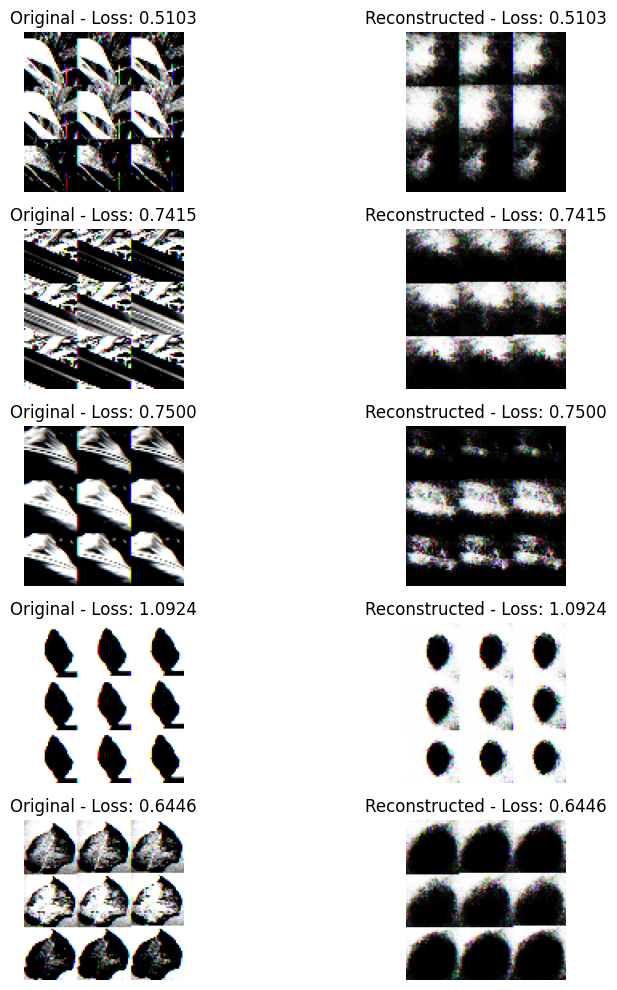

In [5]:
def test_and_visualize_model(model, dataloader, device, num_images_to_show=5):
    model.eval()
    images, outputs, losses = [], [], []

    with torch.no_grad():
        for image_batch, _ in dataloader:
            image_batch = image_batch.view(image_batch.size(0), -1).to(device)
            output_batch = model(image_batch)
            
            # Batch için kayıpları hesapla
            batch_losses = torch.mean((output_batch - image_batch) ** 2, dim=1)
            
            images.extend(image_batch.cpu().numpy())
            outputs.extend(output_batch.cpu().numpy())
            losses.extend(batch_losses.cpu().numpy())
            
            if len(images) >= num_images_to_show:
                break
    
    # Görselleştirme
    plt.figure(figsize=(10, 2 * num_images_to_show))
    for i in range(num_images_to_show):
        # Orijinal Görüntüler
        plt.subplot(num_images_to_show, 2, i * 2 + 1)
        plt.imshow(images[i].reshape(100, 100, 3))
        plt.title(f'Original - Loss: {losses[i]:.4f}')
        plt.axis('off')
        
        # Rekonstrüksiyonlar
        plt.subplot(num_images_to_show, 2, i * 2 + 2)
        plt.imshow(outputs[i].reshape(100, 100, 3))
        plt.title(f'Reconstructed - Loss: {losses[i]:.4f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    return images, outputs, losses

# Modelinizi test edin ve sonuçları görselleştirin
test_images, reconstructed_images, reconstruction_losses = test_and_visualize_model(model, dataloader, device)


In [7]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

example_image = Image.open("./example_images/5.png")
example_image = transform(example_image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    reconstructed_image = model(example_image.view(example_image.size(0), -1))

loss = torch.mean((reconstructed_image - example_image.view(example_image.size(0), -1)) ** 2)

In [8]:
loss

tensor(0.6056, device='cuda:0')